# <span style="color:teal"> Deep Reinforcement with $Improvised^1$ Architecture for</span> <span style="color:red">Atari Enduro-v0 </span>

### Import Required Packages

In [1]:
from time import sleep
from __future__ import division

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Permute
from keras.layers import Input, Conv2D
from keras.optimizers import Adam
from keras.activations import  linear

from keras.layers.advanced_activations import LeakyReLU

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

Using TensorFlow backend.


***
### Enduro-v0 Environment

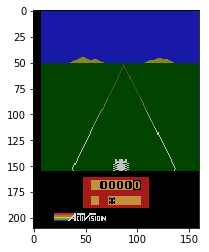

In [2]:
env = gym.make('Enduro-v0')

plt.imshow(env.render(mode='rgb_array'))

#### 1. *Number of possible action*

In [3]:
nb_actions = env.action_space.n
print('Total number of Possible actoin is :', nb_actions)

Total number of Possible actoin is : 9


#### 2. *Taking stack of 4 consecutive frames*

In [4]:
frame_shape = (84, 84)
window_length = 4
input_shape = (window_length,) + frame_shape
print('Input Shape is :', input_shape)

Input Shape is : (4, 84, 84)


***
### Defining class for pre-processing the game_frames

In [5]:
class GameProcess(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = np.array(img.resize(frame_shape).convert('L'))
        return img.astype('uint8')  

    def process_state_batch(self, batch):
        Processed_batch = batch.astype('float32') / 255.
        return Processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

***
## Improvised Architecture

In [6]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (4,4), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.1)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.1)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.1)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.1)(right)
    
    x = concatenate([left, right], axis=3)
    return x

In [7]:
game_input=Input(shape=input_shape)

x = Permute((2, 3, 1))(game_input)

x = Conv2D(32, (8,8), strides=(4, 4))(x)
x = LeakyReLU(alpha=0.1)(x)

x = fire_incept(x, fire=64, intercept=32)

x = fire_squeeze(x, fire=64, intercept=32)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)

out = Dense(nb_actions, activation='linear')(x)

model_new = Model(game_input, out)
model_new.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4, 84, 84)     0                                            
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 84, 84, 4)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 20, 20, 32)    8224        permute_1[0][0]                  
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 20, 20, 32)    0           conv2d_1[0][0]                   
___________________________________________________________________________________________

***
### Configuring the Agent

#### 1. *Allocating memory for experience replay*

In [8]:
Memory = SequentialMemory(limit=1000000, window_length=window_length)

#### 2.* Policy: Epsilon Greedy Exploration*
<span style="color:teal">*Gradually exploration will be decreased*</span>

In [9]:
Policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=1000000)

#### 3. *Compiling DQN Agent*

In [10]:
Dqn = DQNAgent(model=model_new, nb_actions=nb_actions, policy=Policy, memory=Memory, processor=GameProcess(),
               nb_steps_warmup=50000, gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

In [11]:
Dqn.compile(Adam(lr=.00025), metrics=['mae'])

***
# <span style="color:red">**-  -  $ Caution^1 $   -  -**</span>

## <span style="color:teal"> Training the model </span>

#### 1. For 2M Steps

In [12]:
History2M = Dqn.fit(env, nb_steps=2000000)

Training for 2000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 60s - reward: 0.0000e+00    
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 59s - reward: 0.0000e+00    - ETA: 0s - rewa
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 61s - reward: 0.0000e+00    - ETA: 0s - rewa
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 60s - reward: 0.0000e+00    
3 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 59s - reward: 0.0000e+00    
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 6 (50000 steps performed)
1

10000/10000 [==============================] - 239s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.003 - mean_q: 0.004 - mean_eps: 0.708 - ale.lives: 0.000

Interval 34 (330000 steps performed)
10000/10000 [==============================] - 236s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.003 - mean_q: 0.004 - mean_eps: 0.699 - ale.lives: 0.000

Interval 35 (340000 steps performed)
10000/10000 [==============================] - 240s - reward: 0.0000e+00   - ETA: 2s - rewar - ETA
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.003 - mean_q: 0.004 - mean_eps: 0.690 - ale.lives: 0.000

Interval 36 (350000 steps performed)
10000/10000 [==============================] - 241s - reward: 0.0000e+00   
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.004 - mean_q: 0.004 - mean_eps: 

10000/10000 [==============================] - 248s - reward: 0.0000e+00   - 
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.003 - mean_q: 0.004 - mean_eps: 0.429 - ale.lives: 0.000

Interval 65 (640000 steps performed)
10000/10000 [==============================] - 251s - reward: 0.0000e+00   - E
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.003 - mean_q: 0.004 - mean_eps: 0.420 - ale.lives: 0.000

Interval 66 (650000 steps performed)
10000/10000 [==============================] - 250s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.003 - mean_q: 0.004 - mean_eps: 0.411 - ale.lives: 0.000

Interval 67 (660000 steps performed)
10000/10000 [==============================] - 250s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.003 - mean_q: 0.004 - mean_eps: 0.402 - ale.lives:

10000/10000 [==============================] - 262s - reward: -2.0000e-04   
3 episodes - episode_reward: 1.000 [0.000, 3.000] - loss: 0.000 - mean_absolute_error: 0.004 - mean_q: 0.007 - mean_eps: 0.150 - ale.lives: 0.000

Interval 96 (950000 steps performed)
10000/10000 [==============================] - 267s - reward: 3.0000e-04   
2 episodes - episode_reward: 1.500 [0.000, 3.000] - loss: 0.000 - mean_absolute_error: 0.005 - mean_q: 0.008 - mean_eps: 0.141 - ale.lives: 0.000

Interval 97 (960000 steps performed)
10000/10000 [==============================] - 266s - reward: 5.0000e-04   
2 episodes - episode_reward: 2.000 [1.000, 3.000] - loss: 0.001 - mean_absolute_error: 0.003 - mean_q: 0.006 - mean_eps: 0.132 - ale.lives: 0.000

Interval 98 (970000 steps performed)
10000/10000 [==============================] - 267s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.500 [0.000, 1.000] - loss: 0.001 - mean_absolute_error: 0.004 - mean_q: 0.007 - mean_eps: 0.123 - ale.lives: 0.0

10000/10000 [==============================] - 265s - reward: 1.0000e-04   
2 episodes - episode_reward: 0.500 [0.000, 1.000] - loss: 0.003 - mean_absolute_error: 0.058 - mean_q: 0.004 - mean_eps: 0.100 - ale.lives: 0.000

Interval 127 (1260000 steps performed)
10000/10000 [==============================] - 265s - reward: 1.0000e-04   
3 episodes - episode_reward: 0.333 [0.000, 1.000] - loss: 0.003 - mean_absolute_error: 0.056 - mean_q: 0.001 - mean_eps: 0.100 - ale.lives: 0.000

Interval 128 (1270000 steps performed)
10000/10000 [==============================] - 266s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.003 - mean_absolute_error: 0.064 - mean_q: -0.003 - mean_eps: 0.100 - ale.lives: 0.000

Interval 129 (1280000 steps performed)
10000/10000 [==============================] - 265s - reward: 0.0000e+00   -
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.004 - mean_absolute_error: 0.069 - mean_q: -0.004 - mean_eps: 0.100 - ale.li

10000/10000 [==============================] - 265s - reward: 0.0086   
2 episodes - episode_reward: 31.500 [25.000, 38.000] - loss: 0.012 - mean_absolute_error: 0.352 - mean_q: 0.150 - mean_eps: 0.100 - ale.lives: 0.000

Interval 158 (1570000 steps performed)
10000/10000 [==============================] - 265s - reward: 0.0129   
2 episodes - episode_reward: 69.500 [64.000, 75.000] - loss: 0.013 - mean_absolute_error: 0.372 - mean_q: 0.162 - mean_eps: 0.100 - ale.lives: 0.000

Interval 159 (1580000 steps performed)
10000/10000 [==============================] - 264s - reward: 0.0047   
3 episodes - episode_reward: 28.667 [16.000, 46.000] - loss: 0.013 - mean_absolute_error: 0.372 - mean_q: 0.160 - mean_eps: 0.100 - ale.lives: 0.000

Interval 160 (1590000 steps performed)
10000/10000 [==============================] - 264s - reward: 0.0064   
2 episodes - episode_reward: 20.500 [3.000, 38.000] - loss: 0.014 - mean_absolute_error: 0.399 - mean_q: 0.165 - mean_eps: 0.100 - ale.lives: 0.0

10000/10000 [==============================] - 265s - reward: 0.0195   
2 episodes - episode_reward: 93.000 [85.000, 101.000] - loss: 0.025 - mean_absolute_error: 1.089 - mean_q: 0.884 - mean_eps: 0.100 - ale.lives: 0.000

Interval 189 (1880000 steps performed)
10000/10000 [==============================] - 265s - reward: 0.0189   
2 episodes - episode_reward: 78.500 [57.000, 100.000] - loss: 0.027 - mean_absolute_error: 1.110 - mean_q: 0.924 - mean_eps: 0.100 - ale.lives: 0.000

Interval 190 (1890000 steps performed)
10000/10000 [==============================] - 264s - reward: 0.0254   
3 episodes - episode_reward: 105.667 [67.000, 136.000] - loss: 0.029 - mean_absolute_error: 1.167 - mean_q: 0.975 - mean_eps: 0.100 - ale.lives: 0.000

Interval 191 (1900000 steps performed)
10000/10000 [==============================] - 264s - reward: 0.0248   
2 episodes - episode_reward: 108.500 [59.000, 158.000] - loss: 0.031 - mean_absolute_error: 1.198 - mean_q: 0.994 - mean_eps: 0.100 - ale.liv

#### 1.1 Training History

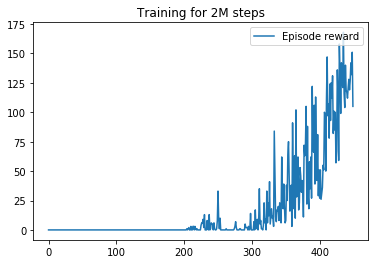

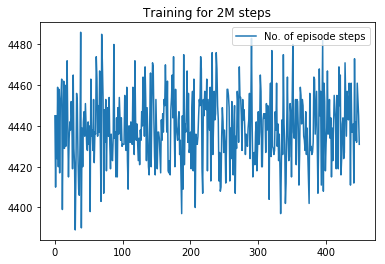

In [13]:
plt.plot(History2M.history['episode_reward'])
plt.title('Training for 2M steps')
plt.legend(['Episode reward'], loc='upper right')
plt.show()

plt.plot(History2M.history['nb_episode_steps'])
plt.title('Training for 2M steps')
plt.legend(['No. of episode steps'], loc='upper right')
plt.show()

#### 1.2 Saving the weights (2M)

In [14]:
Dqn.save_weights('dqn_New_2M.h5f', overwrite=True)

***
### <span style="color:teal"> Re-Training </span>the model (for 1M steps)

#### 2.1 Load Weights

In [15]:
Dqn.load_weights('dqn_New_2M.h5f')

#### 2.2 Compile the DQN Agent with <span style="color:Red">No Exploration</span>

In [16]:
Dqn = DQNAgent(model=model_new, nb_actions=nb_actions, policy=None, memory=Memory, processor=GameProcess(),
               gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

Dqn.compile(Adam(lr=0.00025), metrics=['mae'])

#### 2.3 Fit for 1M Steps

In [17]:
History3M = Dqn.fit(env, nb_steps=1000000)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 253s - reward: 0.0291   
2 episodes - episode_reward: 120.000 [113.000, 127.000] - loss: 0.034 - mean_absolute_error: 1.422 - mean_q: 1.317 - ale.lives: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 268s - reward: 0.0281   
2 episodes - episode_reward: 142.000 [109.000, 175.000] - loss: 0.035 - mean_absolute_error: 1.429 - mean_q: 1.334 - ale.lives: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 269s - reward: 0.0270   
2 episodes - episode_reward: 142.000 [125.000, 159.000] - loss: 0.038 - mean_absolute_error: 1.476 - mean_q: 1.388 - ale.lives: 0.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 269s - reward: 0.0253   - ETA: 0s - 
3 episodes - episode_reward: 95.667 [46.000, 156.000] - loss: 0.038 - mean_absolute_error: 1.527 - mean_q: 1.465 - ale.lives: 0.

10000/10000 [==============================] - 270s - reward: 0.0276   
2 episodes - episode_reward: 129.000 [114.000, 144.000] - loss: 0.048 - mean_absolute_error: 2.290 - mean_q: 2.475 - ale.lives: 0.000

Interval 35 (340000 steps performed)
10000/10000 [==============================] - 266s - reward: 0.0345   
2 episodes - episode_reward: 130.000 [111.000, 149.000] - loss: 0.052 - mean_absolute_error: 2.314 - mean_q: 2.476 - ale.lives: 0.000

Interval 36 (350000 steps performed)
10000/10000 [==============================] - 264s - reward: 0.0331   
3 episodes - episode_reward: 150.000 [111.000, 191.000] - loss: 0.052 - mean_absolute_error: 2.344 - mean_q: 2.505 - ale.lives: 0.000

Interval 37 (360000 steps performed)
10000/10000 [==============================] - 267s - reward: 0.0300   
2 episodes - episode_reward: 153.000 [146.000, 160.000] - loss: 0.053 - mean_absolute_error: 2.392 - mean_q: 2.569 - ale.lives: 0.000

Interval 38 (370000 steps performed)
10000/10000 [===========

10000/10000 [==============================] - 269s - reward: 0.0280   - ETA: - ETA: 0s - reward: 
3 episodes - episode_reward: 129.667 [109.000, 149.000] - loss: 0.051 - mean_absolute_error: 2.892 - mean_q: 3.206 - ale.lives: 0.000

Interval 68 (670000 steps performed)
10000/10000 [==============================] - 269s - reward: 0.0367   
2 episodes - episode_reward: 162.500 [152.000, 173.000] - loss: 0.051 - mean_absolute_error: 2.902 - mean_q: 3.211 - ale.lives: 0.000

Interval 69 (680000 steps performed)
10000/10000 [==============================] - 268s - reward: 0.0265   
2 episodes - episode_reward: 134.000 [119.000, 149.000] - loss: 0.050 - mean_absolute_error: 2.899 - mean_q: 3.216 - ale.lives: 0.000

Interval 70 (690000 steps performed)
10000/10000 [==============================] - 269s - reward: 0.0439   
2 episodes - episode_reward: 179.000 [171.000, 187.000] - loss: 0.051 - mean_absolute_error: 2.930 - mean_q: 3.247 - ale.lives: 0.000

Interval 71 (700000 steps performe

10000/10000 [==============================] - 255s - reward: 0.0343   
done, took 26646.612 seconds


#### 2.4 Training History

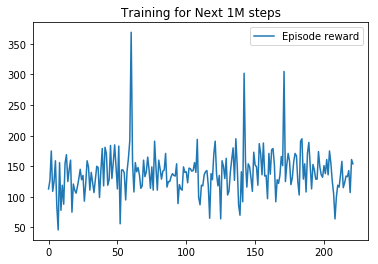

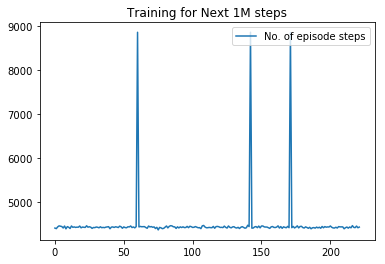

In [18]:
plt.plot(History3M.history['episode_reward'])
plt.title('Training for Next 1M steps')
plt.legend(['Episode reward'], loc='upper right')
plt.show()

plt.plot(History3M.history['nb_episode_steps'])
plt.title('Training for Next 1M steps')
plt.legend(['No. of episode steps'], loc='upper right')
plt.show()

#### 2.5 Saving the weights (3M)

In [19]:
Dqn.save_weights('dqn_New_3M.h5f', overwrite=True)

***
## <span style="color:teal"> Testing the model </span>

#### 1. Resetting the environment for Testing after <span style="color:red">**-  -   2M steps    -  -**</span>

In [25]:
Dqn.load_weights('dqn_New_2M.h5f')

In [26]:
np.random.seed(133)
env.seed(133)
env.reset()
Dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 160.000, steps: 4441
Episode 2: reward: 327.000, steps: 8854
Episode 3: reward: 332.000, steps: 8819
Episode 4: reward: 355.000, steps: 8882
Episode 5: reward: 180.000, steps: 4429


#### 3. Again Reseting the environment for Testing after  <span style="color:red">**-  -   3M steps    -  -**</span>

In [21]:
Dqn.load_weights('dqn_New_3M.h5f')

In [22]:
np.random.seed(133)
env.seed(133)
env.reset()
Dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 396.000, steps: 8853
Episode 2: reward: 148.000, steps: 4442
Episode 3: reward: 351.000, steps: 8819
Episode 4: reward: 402.000, steps: 8882
Episode 5: reward: 421.000, steps: 8866


In [ ]:
# Trained on: Intel® Xeon® Processor E5, 2.40 GHz, Nvidia Quadro K4200
# Bhartendu Thakur, Machine Learning & Computing
# https://in.mathworks.com/matlabcentral/profile/authors/10083740-bhartendu?&detail=fileexchange
# https://in.linkedin.com/in/bhartendu-thakur-56bb6285